# Figure 4a

Correlations stuff

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [3]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = 3300*ureg.s
sim_path = '/media/eru/ina/stuckgs/data/simstair'
data_path = '/media/eru/ina/stuckgs/data/'

## Correlations

Here I will generalte all the correlation timeseries for all realizations for all particles.

In [4]:
data = pd.read_csv(os.path.join(sim_path,'rparallels.csv'), index_col=[0,1])
data

0       1         2         3         4         5  \
realization frame                                                            
1           0     -1.50000 -1.5000  1.500000  1.500000 -1.500000 -1.500000   
            1     -1.41971 -1.2825  0.917301  1.344400 -1.224503 -0.966698   
            2     -0.45348 -1.4624  1.456701  1.034800 -1.386101 -1.027500   
            3     -0.50798 -1.3706  1.074100  1.068501 -1.143803 -1.330700   
            4     -1.05881 -1.1317  1.124500  0.850800 -1.414001 -1.472397   
...                    ...     ...       ...       ...       ...       ...   
10          3295   1.24960 -1.3327  1.492300 -1.487301  0.378799  1.252403   
            3296   1.36498 -1.2177  1.487801 -1.497801  0.118099  1.283302   
            3297   1.38167 -1.4376  1.421600 -1.466499  0.365997  1.355103   
            3298   1.23165 -1.3350  1.485401 -1.497499  0.083897  1.315903   
            3299   1.29295 -1.3901  1.402500 -1.485800 -0.121601  1.364002   

                          6         7         8         9  ...      1790  \
realization frame                                          ...             
1           0     -1.500000  1.500000 -1.500000 -1.500000  ... -1.500000   
            1     -1.336201  1.471603 -1.379402 -1.380402  ... -0.581009   
            2     -1.371800  0.306801 -0.560097 -1.229401  ... -0.506012   
            3     -1.430698  1.145500 -0.441597 -1.179802  ... -1.118011   
            4     -1.137898  0.627800 -1.325699 -1.401199  ... -1.425003   
...                     ...       ...       ...       ...  ...       ...   
10          3295  -1.135899  0.104000  1.116798 -1.119400  ... -1.516007   
            3296  -1.092998 -0.108299  1.125900 -1.214897  ... -1.528000   
            3297  -1.058899 -0.334499  1.170403 -1.144302  ... -1.531006   
            3298  -1.093899 -0.221500  1.109100 -1.213997  ... -1.535004   
            3299  -1.112499 -0.186298  1.148903 -1.157303  ... -1.527008   

                       1791      1792      1793      1794      1795      1796  \
realization frame                                                               
1           0     -1.500000  1.500000 -1.500000 -1.500000 -1.500000 -1.500000   
            1     -0.960007  1.343994 -0.882004 -1.408005 -1.409012 -1.484009   
            2     -1.258011  0.946991 -0.595001 -1.234009 -1.194000 -1.307007   
            3     -1.381012  1.054993 -0.417999 -1.472000 -1.272003 -1.459000   
            4     -1.245010  0.412994 -0.237000 -1.417999 -1.335007 -1.134003   
...                     ...       ...       ...       ...       ...       ...   
10          3295   1.524994  1.529999  1.516998  1.522995  1.504990 -1.542007   
            3296   1.524002  1.515991  1.505997  1.509994  1.520996 -1.531998   
            3297   1.521988  1.505997  1.478989  1.516998  1.513000 -1.542999   
            3298   1.528000  1.505997  1.493988  1.519989  1.526993 -1.524002   
            3299   1.524994  1.513000  1.506989  1.528000  1.511993 -1.540008   

                       1797      1798      1799  
realization frame                                
1           0     -1.500000 -1.500000 -1.500000  
            1     -1.467010 -1.452011 -1.419998  
            2     -1.444000 -0.941010 -0.889999  
            3     -1.273010 -1.029999 -1.453003  
            4     -1.492004 -1.097000 -1.417999  
...                     ...       ...       ...  
10          3295   1.513992  1.513000 -1.529007  
            3296   1.509003  1.524002 -1.529999  
            3297   1.501999  1.516998 -1.541000  
            3298   1.533997  1.528000 -1.542999  
            3299   1.514999  1.534988 -1.527008  

[33000 rows x 1800 columns]

In [5]:
realizations = data.index.get_level_values('realization').unique().to_list()

h = 300
intervals = [
 (30, 330),
 (360, 660),
 (690, 990),
 (1020, 1320),
 (1350, 1650),
 (1680, 1980),
 (2010, 2310),
 (2340, 2640),
 (2670, 2970),
 (3000, 3300),
]

In [6]:
def correlate_realization(sim_path,data,realization,interval,s,e):
    """
        This calculates the correlations functions for all particles in a given time interval.
        Saves all the data.
    """
    
    # Selecting the appropiate realization and its frames
    cdata = data.loc[idx[realization,:]]
    sframes = cdata.index.get_level_values('frame').unique().to_list()
    particle_ids = data.columns
    
    # Selecting all the particles time-selies
    cts = cdata[particle_ids].to_numpy().transpose()
    subselframes, correlations = aux.correlate_bframes(params,cts,sframes,stime=s,etime=e)

    # Making the appropiate df
    corr_df = pd.DataFrame(np.array(correlations).transpose()) # Putting each time-series as columns
    numbered = list(corr_df.columns)
    corr_df['frame'] = subselframes
    corr_df['realization'] = [realization] * len(subselframes)
    corr_df[['realization','frame'] + numbered]

    if realization == 1:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False)
    else:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False, header=False, mode='a')
    


In [7]:
corr_path = '/media/eru/ina/stuckgs/data/figs/correlations'
for i,(s,e) in enumerate(intervals):
    print(f'Interval ({s},{e})')
    for realization in realizations:
        correlate_realization(corr_path,data,realization,i,s,e)

Interval (30,330)
Interval (360,660)
Interval (690,990)
Interval (1020,1320)
Interval (1350,1650)
Interval (1680,1980)
Interval (2010,2310)
Interval (2340,2640)
Interval (2670,2970)
Interval (3000,3300)


## Averages

Now it is time to load them one by one and take the averages, std, normalize and stuff.

In [8]:
for interval in range(len(intervals)):
    avs = []
    for realization in realizations:
        corr_int = pd.read_csv(os.path.join(corr_path,f'corr{interval}.csv'),index_col=['realization','frame'])
        frames = corr_int.index.get_level_values('frame').unique().to_numpy()
        dt = (frames - frames[0]) / params['framespersec'].magnitude
        
        particle_average = corr_int.loc[idx[realization,:]].mean(axis=1)
        particle_average = particle_average / particle_average.max()
        avs.append(particle_average.to_list())

    df = pd.DataFrame( np.array(avs).mean(axis=0), columns=['av'])
    df['dt'] = dt
    df['interval'] = [interval] * len(frames)

    if interval == 0:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False)
    else:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False,mode = 'a', header=False)



## Visualization

In [9]:
corravs = pd.read_csv(os.path.join(corr_path,'global.csv'), index_col=['interval','dt'])
nintervals = corravs.index.get_level_values('interval').unique().to_list()

In [10]:
rate = params['max_field']/quench_time
fields = [1,2,3,4,5,6,7,8,9,10]
fields


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

/tmp/ipykernel_19381/3355398497.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,h)


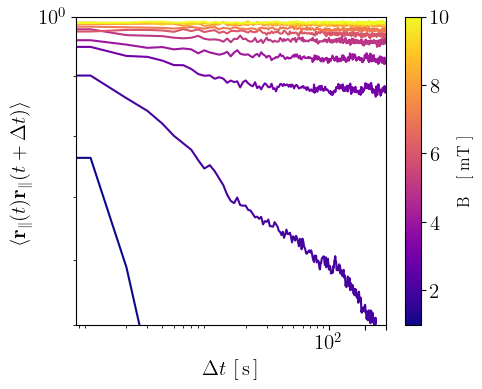

In [16]:
fig, ax = plt.subplots(figsize = (5,4))
cmap = plt.get_cmap('plasma')

for interval, (i,B) in zip(nintervals, enumerate(fields)):
    color =  cmap(i / (len(fields) - 1))
    avi = corravs.loc[idx[interval,'av']]
    ax.loglog(avi.index.to_list(),avi.to_list(), color=color)
    #ax.plot(avi.index.to_list(),avi.to_list(), color=color)

ax.set_xlim(0,h)
ax.set_ylim(0.9,1)
ax.set_xlabel("$\\Delta t$ [\\,s\\,]", fontsize=15)
ax.set_ylabel("$\\langle \\mathbf{r}_\\parallel(t) \\mathbf{r}_\\parallel(t+\\Delta t)\\rangle$",fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(100))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

ax.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=10))
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label(label='B \\,\\, [ mT ]',size='large')
cbar.ax.tick_params(labelsize=15)

fig.savefig(os.path.join(data_path,'figs/fig4a.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join(data_path,'figs/fig4a.pdf'))

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy